## Import necessary modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import re
from string import punctuation

import nltk
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

## Load Data

In [2]:
# read the train csv file
train_df = pd.read_csv(r"train.csv")

# read the test csv file
test_df = pd.read_csv(r"test.csv")

# read the submission csv file
submission = pd.read_csv(r"sample_submission.csv")

## Explore Data

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df.shape

(7613, 5)

In [6]:
test_df.shape

(3263, 4)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
train_df.describe(include='all')

,id,keyword,location,text,target
count,7613.00,7552,5080,7613,7613.00
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.93,NaN,NaN,NaN,0.43
std,3137.12,NaN,NaN,NaN,0.50
min,1.00,NaN,NaN,NaN,0.00
25%,2734.00,NaN,NaN,NaN,0.00
50%,5408.00,NaN,NaN,NaN,0.00
75%,8146.00,NaN,NaN,NaN,1.00


In [10]:
test_df.describe(include='all')

,id,keyword,location,text
count,3263.00,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.15,NaN,NaN,NaN
std,3146.43,NaN,NaN,NaN
min,0.00,NaN,NaN,NaN
25%,2683.00,NaN,NaN,NaN
50%,5500.00,NaN,NaN,NaN
75%,8176.00,NaN,NaN,NaN


In [11]:
print(train_df.target.value_counts())

0    4342
1    3271
Name: target, dtype: int64


In [12]:
train_df.keyword.unique()[:20]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze'],
      dtype=object)

In [13]:
train_df.location.unique()[:20]

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa'], dtype=object)

## Visualizing the Tweets

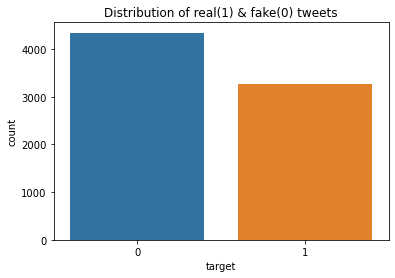

In [14]:
sns.countplot( x = "target", data = train_df)
plt.title("Distribution of real(1) & fake(0) tweets")
plt.show()

## Pre-processing & EDA

In [15]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [16]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [17]:
del train_df['id']
del train_df['keyword']
del train_df['location']

del test_df['id']
del test_df['keyword']
del test_df['location']

In [18]:
train_df.head(3)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1


In [19]:
test_df.head(3)

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."


## Function to clean the data

In [20]:
def clean_text(text):
    punctuation = '''0123456789!()-[]:;"\,<>./?@#$%^_~*&{}'''
    nopunc = [char for char in text if char not in punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Split the Dataset

In [21]:
X = train_df["text"].to_numpy()
y = train_df["target"].to_numpy()

# splitting the data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(6851, 762, 6851, 762)

## Text Normalization Using TfidfVectorizer

In [22]:
vectorizer = TfidfVectorizer(use_idf=True, analyzer=clean_text, ngram_range=(1,3), min_df=1, stop_words='english')

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

test_texts = vectorizer.transform(test_df["text"])

## Model Building

In [23]:
model = MultinomialNB().fit(X_train, y_train)

In [24]:
y_pred = model.predict(X_test)

## Metrics

### Accuracy Score

In [25]:
print("Accuracy Score is =",accuracy_score(y_test, y_pred))

Accuracy Score is = 0.7742782152230971


### Confusion Matrix

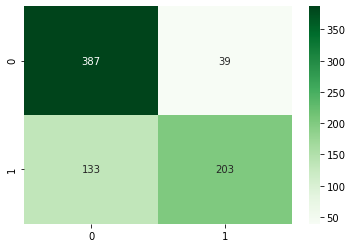

In [26]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens', fmt='.3g')

### Classification Report

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       426
           1       0.84      0.60      0.70       336

    accuracy                           0.77       762
   macro avg       0.79      0.76      0.76       762
weighted avg       0.79      0.77      0.77       762



## Submission

In [28]:
submission["target"] = model.predict(test_texts)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [29]:
submission.to_csv('Submission.csv', index=False)

In [30]:
df = pd.read_csv('Submission.csv')

In [31]:
df.shape

(3263, 2)

In [32]:
df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
